# Data Exploration using a predefined set of gaming channels.
---

**Goal:** 

The goal of this part is to explore and propose first insights on the sample dataset obtained by filtering channels data from the `time_series` and `channels` dataset.

**Process to Obtain the Dataset:** 

As mentioned above, in this part, we will work using a small sample of the original dataset. This sample was obtained (see `general_data_exploration.ipynb`) by keeping only Gaming YouTubers that we labeled to precise games. \
We chose to restrict ourselves to these following categories ***[MobileGames (e.g Clash of Clans), Gaming News (channels that post videos about updates and news on games), Grand Theft Auto (GTA), League of Legends (LOL), FIFA, Call of Duty (COD), Fortnite, Minecraft]***. From these categories, using internet YouTube forums and YouTube research, we selected for each category at least 5 channels that produce exclusively content of these categories (e.g., the I JACK SPARROW COC channel is dedicated to Clash of Clans).
Finally we filtered the time series tp keep only thos channels and their 'new' tag, and we merged any useful information that could come from the channels dataset in the time series.

---

### Import and Load 

In [24]:
# General lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Stats lib
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats import diagnostic
from scipy import stats
import scipy.fft as sf

# Plot lib
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Plot tuning
%matplotlib inline
sns.set()

In [2]:
# Load the data
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t')
df_sample_channels = pd.read_parquet('data/df_sample_channels.parquet')
df_sample_timeseries = pd.read_parquet('data/df_sample_timeseries.parquet')

---
### Data Understanding and preparation

#### Channels

In [3]:
# Sample Channels df
print(f'{df_sample_channels.name_cc.nunique()} unique channels')
df_sample_channels.head()

56 unique channels


,name_cc,game_category
0,Klaus Gaming,Mobile Games
1,Past Amazing,Mobile Games
2,I JACK SPARROW COC,Mobile Games
3,Galadon Gaming,Mobile Games
4,Orange Juice Gaming,Mobile Games


This sample channels dataframe contains the 56 Youtubers we selected and their respective gamine category (i.e the game they are playing on the most).

Let's merge it with the general channels dataset to analyse the stats of the channeles we selected.

In [4]:
# Channels df
df_channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [5]:
# We merge this dataset with our set of selected channels
df_sample_gaming_channels = df_sample_channels.merge(right=df_channels, on='name_cc')
display(df_sample_gaming_channels.head())

# Display the features of our data 
display(df_sample_gaming_channels.columns)

,name_cc,game_category,category_cc,join_date,channel,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Klaus Gaming,Mobile Games,Gaming,2015-11-03,UCN35DM_vPpMz6zPBxeBRWIA,427000,1400,40344.0,3.3215
1,Past Amazing,Mobile Games,Gaming,2016-03-19,UCDwUgJv9ZsPPZq6CajOFLNg,334000,340,49692.0,3.3915
2,I JACK SPARROW COC,Mobile Games,Gaming,2013-11-15,UCWBQKvXstY4yCLQpGvfB1Ug,153981,841,117055.0,4.4920
3,Galadon Gaming,Mobile Games,Gaming,2013-06-12,UC2l8G7UE41Vaby59Dfg6r3w,1760000,2246,7716.0,2.5460
4,Orange Juice Gaming,Mobile Games,Gaming,2015-04-21,UC3S6nIDGJ5OtpC-mbvFA8Ew,1415172,684,9667.0,2.5920


Index(['name_cc', 'game_category', 'category_cc', 'join_date', 'channel',
       'subscribers_cc', 'videos_cc', 'subscriber_rank_sb', 'weights'],
      dtype='object')

First we can drop the general category indicator as now all our channels are sample from the Gaming category. In addition, we can drop `weights` we won't use it in our analysis.

In [6]:
df_sample_gaming_channels = df_sample_gaming_channels.drop(columns=['category_cc', 'weights'])

In [7]:
# Lets look to the format of our new dataset and some stats about its numerical features
df_sample_gaming_channels.info()
df_sample_gaming_channels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name_cc             56 non-null     object 
 1   game_category       56 non-null     object 
 2   join_date           56 non-null     object 
 3   channel             56 non-null     object 
 4   subscribers_cc      56 non-null     int64  
 5   videos_cc           56 non-null     int64  
 6   subscriber_rank_sb  56 non-null     float64
dtypes: float64(1), int64(2), object(4)
memory usage: 3.2+ KB


,subscribers_cc,videos_cc,subscriber_rank_sb
count,5.600000e+01,56.000000,56.000000
mean,6.514148e+06,4519.035714,13423.482143
std,5.557279e+06,17796.865582,29408.582542
min,1.010000e+05,149.000000,104.000000
25%,1.441293e+06,668.750000,498.000000
50%,5.665000e+06,1942.500000,1380.500000
75%,1.060000e+07,3224.000000,9222.250000
max,2.240000e+07,134606.000000,137394.000000


We observe a high variance among the channels we selected; some appear to be top channels with more than 20 million subscribers, while others are smaller channels with less than a million. This is not a significant issue, as some of the categories we chose could potentially attract a smaller audience due to their high specificity (not everyone might like FIFA).

However, before undertaking similar introductory work with the timeseries dataset, let's change the format of our data to suitable formats (date...) and check for any missing values.


In [8]:
# We can convert name of the channel, game category and channel id to category and the join date to date format
df_sample_gaming_channels[['name_cc', 'game_category', 'channel']] = df_sample_gaming_channels[['name_cc', 'game_category', 'channel']].astype('category')
df_sample_gaming_channels['join_date'] = pd.to_datetime(df_sample_gaming_channels['join_date'])

In [9]:
# Nan check
display(df_sample_gaming_channels.isna().mean())

name_cc               0.0
game_category         0.0
join_date             0.0
channel               0.0
subscribers_cc        0.0
videos_cc             0.0
subscriber_rank_sb    0.0
dtype: float64

#### Timeseries

In [10]:
# Check 
display(df_sample_timeseries.columns)
df_sample_timeseries.head()

Index(['channel', 'category', 'datetime', 'views', 'delta_views', 'subs',
       'delta_subs', 'videos', 'delta_videos', 'activity', 'channel_name',
       'game_category'],
      dtype='object')

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,channel_name,game_category
1,UCpGdL9Sn3Q5YWUH2DVUW1Ug,Gaming,2016-10-17 00:00:00,6.756017e+09,4.745762e+07,9.224396e+06,73457.375000,3266,11,26,PopularMMOs,Minecraft
2,UCpGdL9Sn3Q5YWUH2DVUW1Ug,Gaming,2016-10-24 00:00:00,6.802824e+09,4.680721e+07,9.284667e+06,60270.875000,3280,14,29,PopularMMOs,Minecraft
3,UCpGdL9Sn3Q5YWUH2DVUW1Ug,Gaming,2016-10-30 23:00:00,6.849790e+09,4.696586e+07,9.333509e+06,48841.865285,3292,12,31,PopularMMOs,Minecraft
4,UCpGdL9Sn3Q5YWUH2DVUW1Ug,Gaming,2016-11-06 23:00:00,6.890571e+09,4.078041e+07,9.375919e+06,42410.384715,3304,12,28,PopularMMOs,Minecraft
5,UCpGdL9Sn3Q5YWUH2DVUW1Ug,Gaming,2016-11-13 23:00:00,6.931459e+09,4.088798e+07,9.427722e+06,51803.244792,3318,14,28,PopularMMOs,Minecraft


In [11]:
# Drop of the common category
df_sample_timeseries = df_sample_timeseries.drop(columns='category')

# Safety check that the timeseries that we have is compatible with the channels we selected
print(f'{df_sample_timeseries.channel_name.nunique()} unique channels')
df_sample_timeseries.channel_name.value_counts().reset_index()

56 unique channels


,channel_name,count
0,PopularMMOs,154
1,TheXclusiveAce,154
2,Sky Does Everything,154
3,Logdotzip,154
4,CaptainSparklez,154
5,DanTDM,154
6,I JACK SPARROW COC,154
7,RaidAway,154
8,The Game Theorists,154
9,Trick2G,154


The dataset indeed contains the same number of channels. Moreover, all the channels are observed during the same intervals.

In [12]:
# Info, stats and Nan check
df_sample_timeseries.info()
df_sample_timeseries.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 8624 entries, 1 to 8733
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   channel        8624 non-null   object        
 1   datetime       8624 non-null   datetime64[ns]
 2   views          8624 non-null   float64       
 3   delta_views    8624 non-null   float64       
 4   subs           8624 non-null   float64       
 5   delta_subs     8624 non-null   float64       
 6   videos         8624 non-null   int64         
 7   delta_videos   8624 non-null   int64         
 8   activity       8624 non-null   int64         
 9   channel_name   8624 non-null   object        
 10  game_category  8624 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 808.5+ KB


,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
count,8624,8.624000e+03,8.624000e+03,8.624000e+03,8624.000000,8624.000000,8624.000000,8624.000000
mean,2018-04-05 11:35:03.896104192,1.522490e+09,7.251474e+06,4.622299e+06,22722.931057,2529.666628,6.883001,15.155844
min,2016-10-17 00:00:00,1.669288e+04,0.000000e+00,1.795000e+02,0.000000,0.000000,0.000000,0.000000
25%,2017-07-10 00:00:00,1.843935e+08,7.092354e+05,8.836051e+05,1245.565104,399.000000,1.000000,4.000000
50%,2018-04-05 12:00:00,5.627398e+08,2.395787e+06,2.942865e+06,6413.708333,1610.000000,5.000000,11.000000
75%,2018-12-30 23:00:00,1.820255e+09,7.656270e+06,7.743059e+06,22515.031250,2758.250000,7.000000,16.000000
max,2019-09-23 00:00:00,1.551577e+10,2.044085e+08,2.241518e+07,891824.451380,55942.000000,285.000000,494.000000
std,NaN,2.467927e+09,1.197596e+07,4.668478e+06,50708.463306,6312.789088,15.239512,32.101595


In [13]:
# As we did previously lets convert object to suitable format
df_sample_timeseries[['channel', 'channel_name', 'game_category']] = df_sample_timeseries[['channel', 'channel_name', 'game_category']].astype('category')

In [14]:
# NaN check
display(df_sample_timeseries.isna().mean())

channel          0.0
datetime         0.0
views            0.0
delta_views      0.0
subs             0.0
delta_subs       0.0
videos           0.0
delta_videos     0.0
activity         0.0
channel_name     0.0
game_category    0.0
dtype: float64

---
### Feature exploration

Now that the two datasets are clean and ready to be explored, let's dive into the channels dataset.

#### Channels

In [15]:
df_sample_gaming_channels

,name_cc,game_category,join_date,channel,subscribers_cc,videos_cc,subscriber_rank_sb
0,Klaus Gaming,Mobile Games,2015-11-03,UCN35DM_vPpMz6zPBxeBRWIA,427000,1400,40344.0
1,Past Amazing,Mobile Games,2016-03-19,UCDwUgJv9ZsPPZq6CajOFLNg,334000,340,49692.0
2,I JACK SPARROW COC,Mobile Games,2013-11-15,UCWBQKvXstY4yCLQpGvfB1Ug,153981,841,117055.0
3,Galadon Gaming,Mobile Games,2013-06-12,UC2l8G7UE41Vaby59Dfg6r3w,1760000,2246,7716.0
4,Orange Juice Gaming,Mobile Games,2015-04-21,UC3S6nIDGJ5OtpC-mbvFA8Ew,1415172,684,9667.0
5,IGN,Gaming News,2006-09-19,UCKy1dAqELo0zrOtPkf0eTMw,12400000,134606,333.0
6,The Game Theorists,Gaming News,2009-08-22,UCo_IB5145EVNcf8hw1Kku7w,12000000,515,370.0
7,League of Legends,Gaming News,2009-02-09,UC2t5bjwHdUX4vM2g8TRDq5g,11000000,1004,433.0
8,Fortnite,Gaming News,2014-01-17,UClG8odDC8TS6Zpqk9CGVQiQ,7200000,322,774.0
9,PlayStation,Gaming News,2005-12-16,UC-2Y8dQb0S6DtpxNgAKoJKA,8960000,11582,604.0


In [56]:
# Extract year from join_date
df_sample_gaming_channels['join_year'] = pd.to_datetime(df_sample_gaming_channels['join_date']).dt.year

# Count occurrences per year
df_counts = df_sample_gaming_channels.groupby(['join_year', 'game_category']).size().reset_index(name='count')

# Create a list of all years between 2005 and 2016
all_years = list(range(2005, 2017))

# Set a custom color palette
color_palette = px.colors.qualitative.Plotly

# Create a bar plot with the specified color palette
fig = px.bar(df_counts, x='join_year', y='count', color='game_category',
             labels={'join_year': 'Join Year', 'count': 'Frequency'},
             text='count',
             title='Distribution of Join Dates by Game Category (Per Year)',
             color_discrete_sequence=color_palette)

# Set category orders for the x-axis (join_year)
fig.update_xaxes(categoryorder='array', categoryarray=all_years)

# Show the plot
fig.show()

Using this plot and the dataframe we note that some channels were created before 2010 and most of the others after 2012, looking at the table we note that these old channels seems also the most famous one.

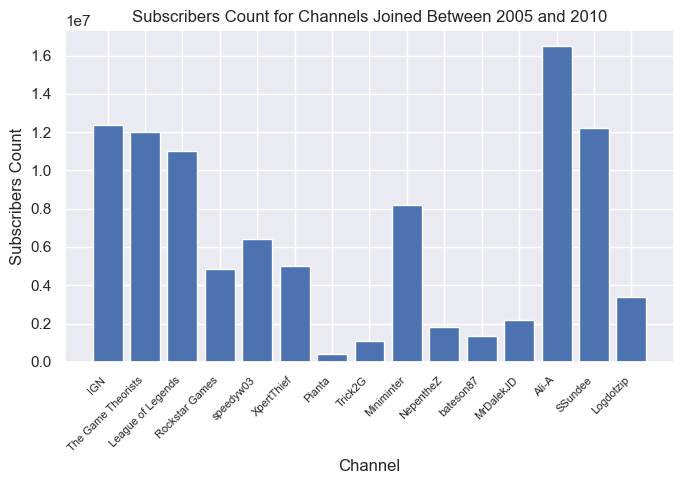

In [17]:
# Display Sub for channels join before 2010
channels_before_2010 = df_sample_gaming_channels[(df_sample_gaming_channels['join_date'].dt.year > 2005) & (df_sample_gaming_channels['join_date'].dt.year < 2010)]

# Plot subscribers count
plt.figure(figsize=(7, 5))
plt.bar(channels_before_2010['name_cc'], channels_before_2010['subscribers_cc'])
plt.title('Subscribers Count for Channels Joined Between 2005 and 2010')
plt.xlabel('Channel')
plt.ylabel('Subscribers Count')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

Looking at the oldest channels, finally, some are famous, but others are not at all. Starting a long time ago seems to not imply fame.

Lets analyse the differences between the game category in terms of subscriber count, videos count and subscriber rank. 

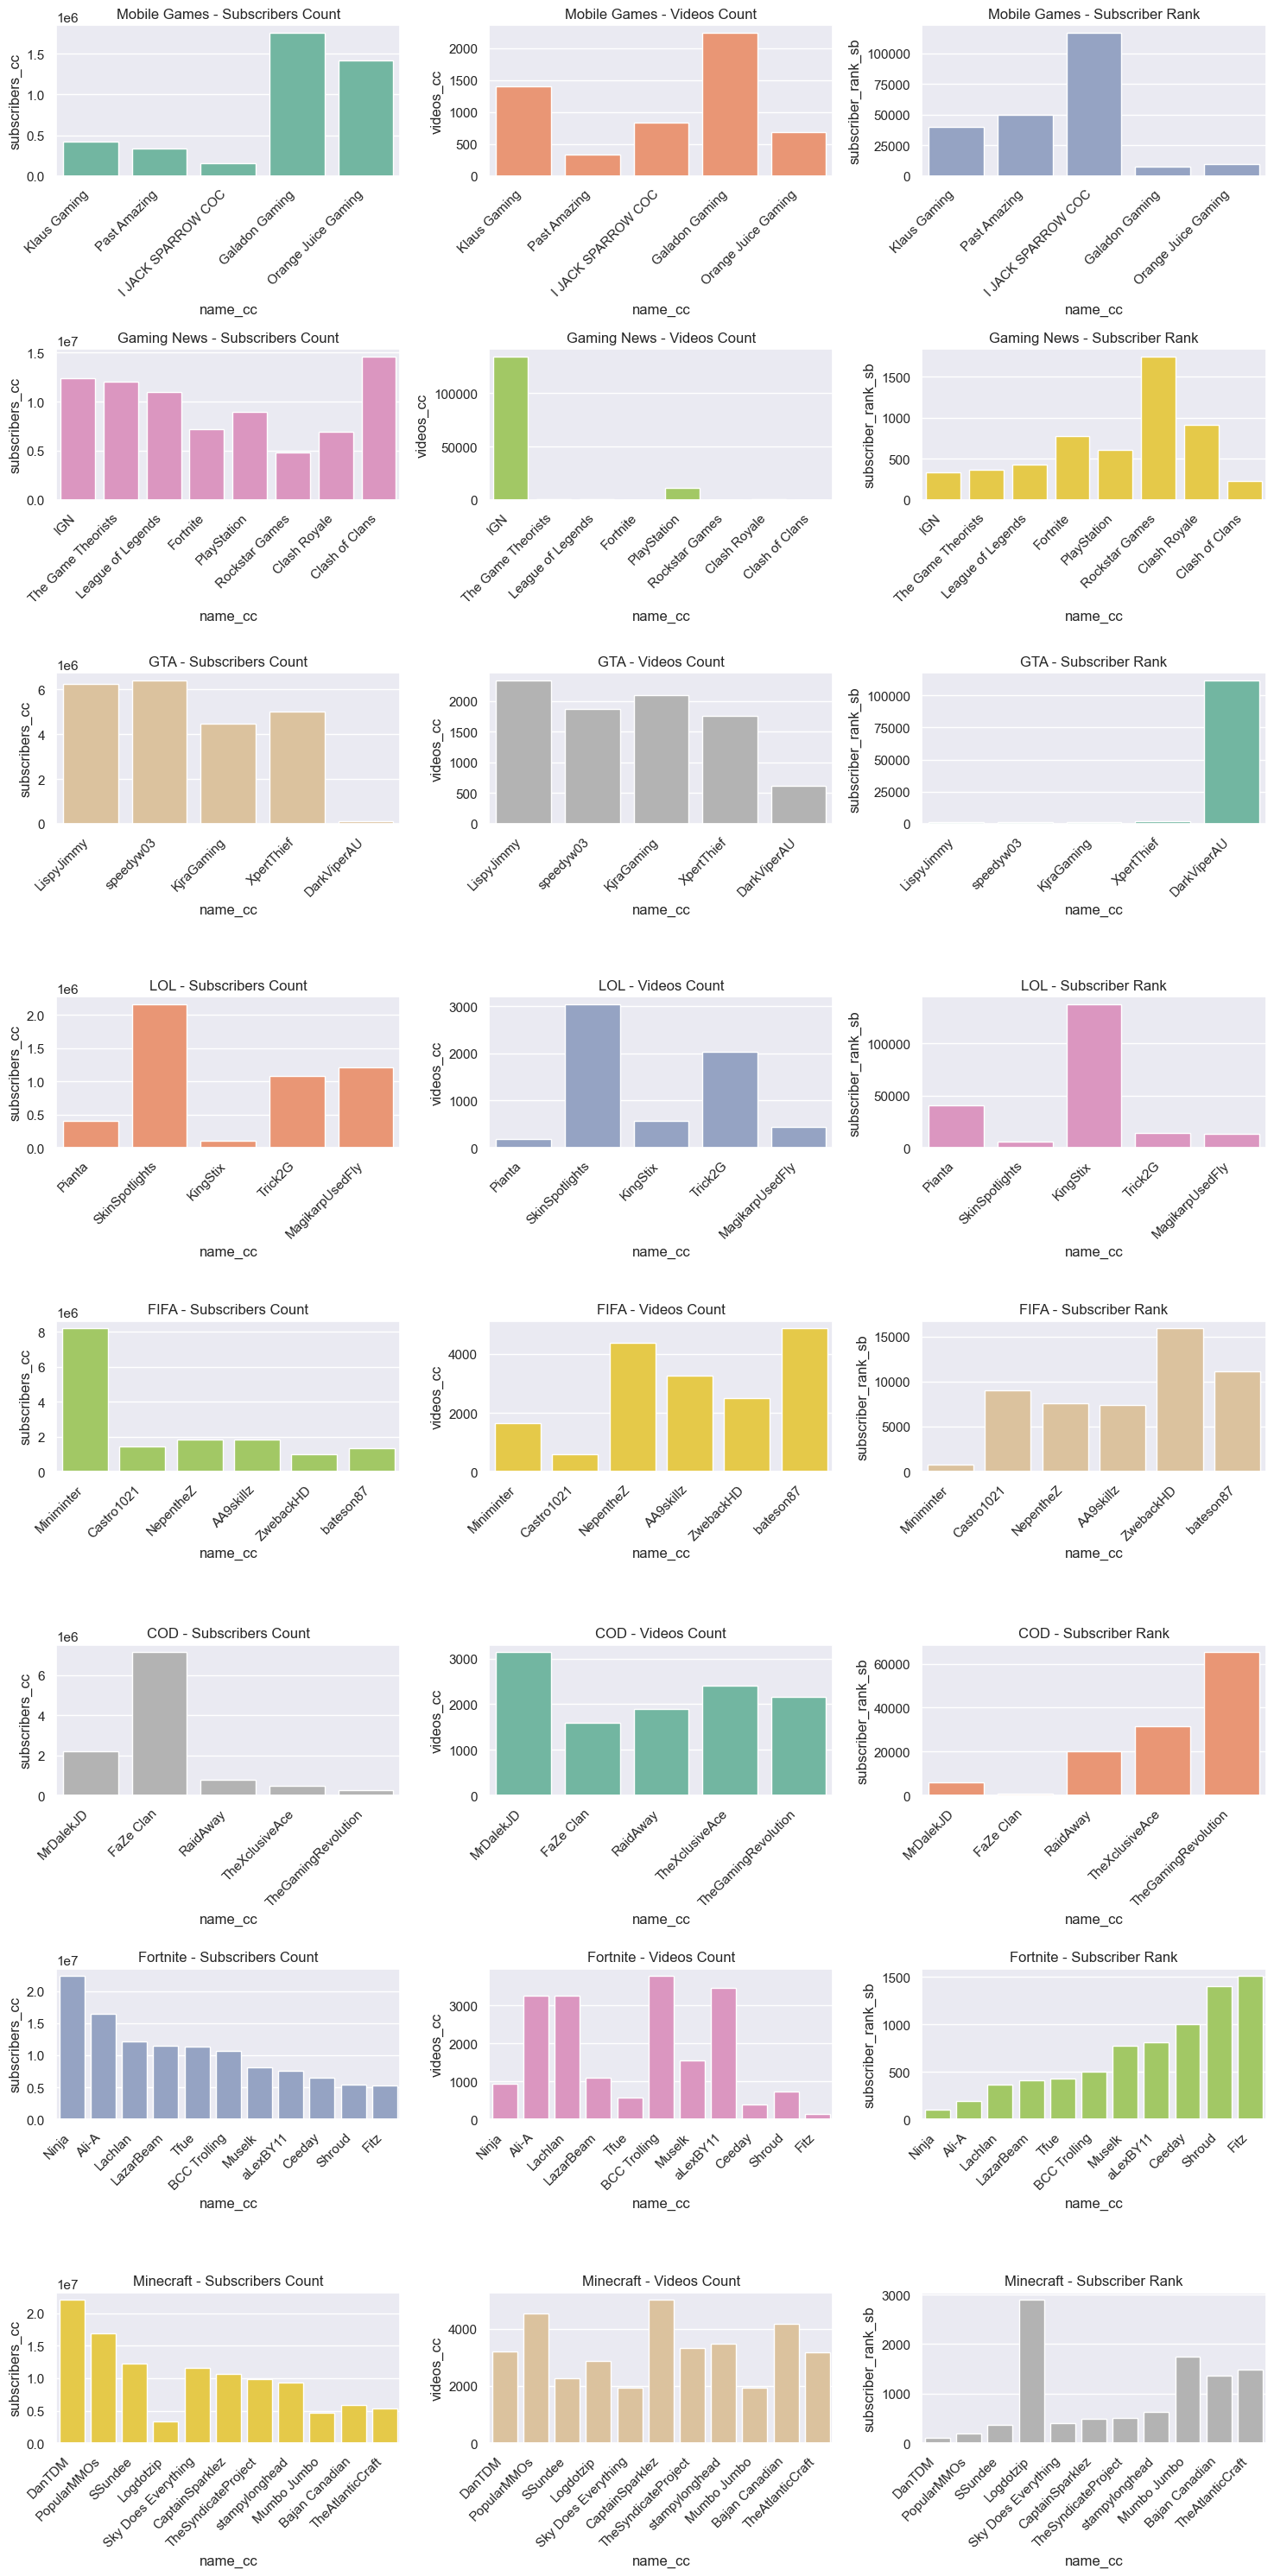

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

# Assuming df_sample_gaming_channels is your DataFrame

# Define the number of categories
num_categories = len(df_sample_gaming_channels['game_category'].unique())

# Get a qualitative colormap from Matplotlib
cmap = plt.get_cmap("Set2")
color_palette = cycle([cmap(i) for i in range(num_categories)])

# Display a multi plot of the data distribution per channel per categories
rows = 8  
cols = 3  
fig, axes = plt.subplots(rows, cols, figsize=(15, 30))
axes = axes.flatten()

for i, game_category in enumerate(df_sample_gaming_channels['game_category'].unique()):
    subset = df_sample_gaming_channels[df_sample_gaming_channels['game_category'] == game_category]
    
    # Simple bar plot
    sns.barplot(x=subset.name_cc.astype(str), y='subscribers_cc', data=subset, ax=axes[i * cols], palette=[next(color_palette)])
    axes[i * cols].set_title(f'{game_category} - Subscribers Count')

    sns.barplot(x=subset.name_cc.astype(str), y='videos_cc', data=subset, ax=axes[i * cols + 1], palette=[next(color_palette)])
    axes[i * cols + 1].set_title(f'{game_category} - Videos Count')

    sns.barplot(x=subset.name_cc.astype(str), y='subscriber_rank_sb', data=subset, ax=axes[i * cols + 2], palette=[next(color_palette)])
    axes[i * cols + 2].set_title(f'{game_category} - Subscriber Rank')

    # readability settings
    for ax in axes[i * cols:i * cols + 3]:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Comments:** 

We can observe that, in terms of subscribers, Minecraft, Fortnite, and Gaming News channels are above the others, reaching the 1e7 (10 million) mark. Within each category, the YouTubers' fame also varies significantly; some YouTubers are extremely popular compared to others in the same category. For example, in the FIFA category, Miniminter is much more famous than the others, and the same holds true for SkinSpotlights in League of Legends (LOL).

It's worth noting that the most famous channels are not necessarily the ones with the highest number of videos. Moreover, in terms of the general ranking, every category seems to contain channels that are among the top in the YouTube subscriber ranking.

Additionally, in Grand Theft Auto (GTA), LOL, and FIFA, there is a notable difference between some of the YouTubers

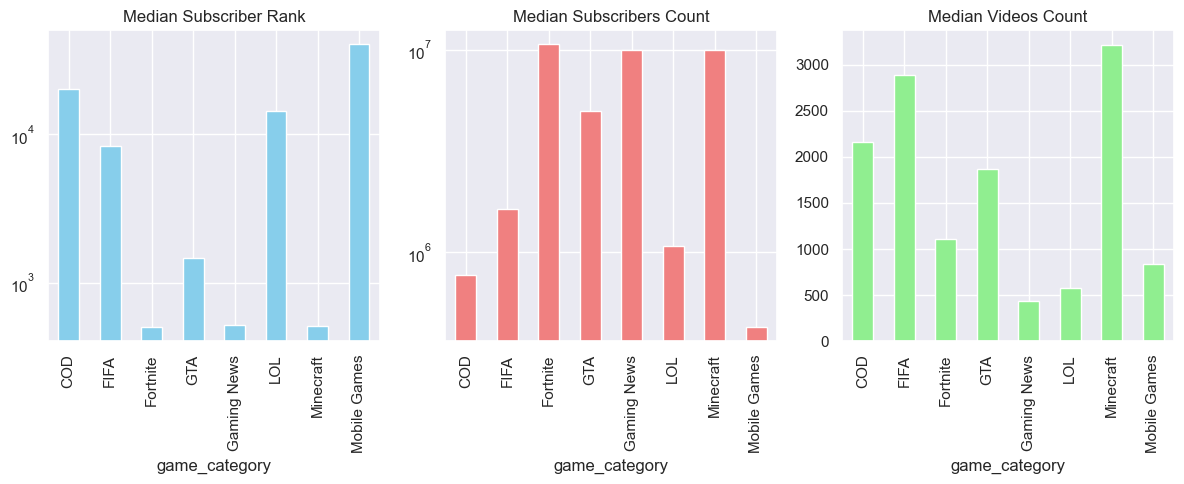

In [19]:
# Let's visualize the same graph but this time by game category taking the median of the values in each category (outlier robustness)
grouped = df_sample_gaming_channels.groupby('game_category')[['subscribers_cc', 'videos_cc', 'subscriber_rank_sb']].median()

# Subplots settings
rows = 1  
cols = 3  
fig, axes = plt.subplots(rows, cols, figsize=(12, 5)) 
axes = axes.flatten()

# Bar plots for each metric
grouped['subscriber_rank_sb'].plot(kind='bar', ax=axes[0], color='skyblue') 
axes[0].set_title('Median Subscriber Rank')
axes[0].set_yscale('log')

grouped['subscribers_cc'].plot(kind='bar', ax=axes[1], color='lightcoral')  
axes[1].set_title('Median Subscribers Count')
axes[1].set_yscale('log')

grouped['videos_cc'].plot(kind='bar', ax=axes[2], color='lightgreen')  
axes[2].set_title('Median Videos Count')

plt.tight_layout()
plt.show()


In [55]:
import plotly.express as px

# Assuming grouped is a DataFrame containing the grouped median values as you've calculated

# Define a colorblind-friendly palette
color_palette = px.colors.qualitative.Plotly

# Bar plot for 'Median Subscriber Rank'
fig1 = px.bar(grouped, x=grouped.index, y='subscriber_rank_sb', color='subscriber_rank_sb',
             labels={'subscriber_rank_sb': 'Median Subscriber Rank'},
             title='Median Subscriber Rank', color_discrete_sequence=color_palette)
fig1.update_layout(yaxis_type='log')  # Set y-axis to log scale

# Bar plot for 'Median Subscribers Count'
fig2 = px.bar(grouped, x=grouped.index, y='subscribers_cc', color='subscribers_cc',
             labels={'subscribers_cc': 'Median Subscribers Count'},
             title='Median Subscribers Count', color_discrete_sequence=color_palette)
fig2.update_layout(yaxis_type='log')  # Set y-axis to log scale

# Bar plot for 'Median Videos Count'
fig3 = px.bar(grouped, x=grouped.index, y='videos_cc', color='videos_cc',
             labels={'videos_cc': 'Median Videos Count'},
             title='Median Videos Count', color_discrete_sequence=color_palette)

# Create subplots
fig = make_subplots(rows=1, cols=3, shared_xaxes=True,
                    subplot_titles=['Median Subscriber Rank', 'Median Subscribers Count', 'Median Videos Count'])

# Add traces to subplots
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)
fig.add_trace(fig3['data'][0], row=1, col=3)

# Update layout
fig.update_layout(height=400, showlegend=False)

# Show the plot
fig.show()


Looking at the median distribution, we confirm that Fortnite and Minecraft contains channels with lowest rank and then the highest subscriber count. See also the high number of FIFA and Minecraft videos in comparison with LOL or Fortnite.

Note that the youtubers we selected are only a sample of these categories but as we selected the top youtubers of these categories they should be representative of each games.

#### Timeseries

In [57]:
df_sample_timeseries.head()

,channel,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,channel_name,game_category
1,UCpGdL9Sn3Q5YWUH2DVUW1Ug,2016-10-17 00:00:00,6.756017e+09,4.745762e+07,9.224396e+06,73457.375000,3266,11,26,PopularMMOs,Minecraft
2,UCpGdL9Sn3Q5YWUH2DVUW1Ug,2016-10-24 00:00:00,6.802824e+09,4.680721e+07,9.284667e+06,60270.875000,3280,14,29,PopularMMOs,Minecraft
3,UCpGdL9Sn3Q5YWUH2DVUW1Ug,2016-10-30 23:00:00,6.849790e+09,4.696586e+07,9.333509e+06,48841.865285,3292,12,31,PopularMMOs,Minecraft
4,UCpGdL9Sn3Q5YWUH2DVUW1Ug,2016-11-06 23:00:00,6.890571e+09,4.078041e+07,9.375919e+06,42410.384715,3304,12,28,PopularMMOs,Minecraft
5,UCpGdL9Sn3Q5YWUH2DVUW1Ug,2016-11-13 23:00:00,6.931459e+09,4.088798e+07,9.427722e+06,51803.244792,3318,14,28,PopularMMOs,Minecraft


In [58]:
# General timeseries 2015 2019
categorized_sample_df = df_sample_timeseries.groupby(['game_category', 'datetime'])[['views', 'delta_views', 'subs', 'delta_subs', 'videos', 'delta_videos']].mean().reset_index().groupby('game_category')


game_categories = list(categorized_sample_df.groups.keys())
N = len(game_categories)
print(f'Videos of {N} different games categories')

Videos of 8 different games categories


In [59]:
# Sample (without Fortnite) timeseries 2015 2018
df_sample_timeseries['game_category'] = df_sample_timeseries['game_category'].astype(object)
filter_timeseries_df = df_sample_timeseries[df_sample_timeseries['datetime'] < '2018-01-01']
filter_timeseries_df = filter_timeseries_df[filter_timeseries_df['game_category'] != 'Fortnite']
categorized_filter_df = filter_timeseries_df.groupby(['game_category', 'datetime'])[['views', 'delta_views', 'subs', 'delta_subs', 'videos', 'delta_videos']].mean().reset_index().groupby('game_category')

game_categories = list(categorized_filter_df.groups.keys())
N = len(game_categories)
print(f'Videos of {N} different games categories')

Videos of 7 different games categories


##### Helpers

In [60]:
import plotly.express as px

def timeseries_correlations(df, feature, verbose=False):
    """Method to compute the timeseries categories correlations

    Args:
        df: the categories dataframe
        feature: the observed feature
        verbose (bool, optional): whether you want to print the results

    Returns:
        corrs: the correlations numpy array
    """
    corrs = np.zeros(shape=(N,N))
    for i, (category_a, category_a_df) in enumerate(df):
        for j, (category_b, category_b_df) in enumerate(df):   
            corrs[i,j] = stats.pearsonr(category_a_df[feature], category_b_df[feature])[0]
            if verbose:
                print('-'*30)
                print(f"{category_a}-{category_b}")
                print(f"Delta subs Corr. : {corrs[i,j]}")
    return corrs

def fourier_plot(df, feature):
    """Helper method to generate the fourier and timeseries analysis plot

    Args:
        df: the categories dataframe
        feature: the observed feature
    """
    fig, axs = plt.subplots(N, 1, figsize=(15, 3 * N), sharex='col')
    fig.suptitle(f"{feature} timeseries and its FT")

    # Create a color palette for each category
    palette = sns.color_palette("husl", n_colors=N)

    for i, (category, category_df) in enumerate(df):
        # Timeseries Plot
        sns.lineplot(category_df, x='datetime', y=feature, ax=axs[i, 0], color=palette[i])
        #sns.regplot(category_df, x='datetime', y=feature, ax=axs[i, 0], scatter=False, color='red')
        axs[i, 0].set_title(f'Timeseries - {category}')
        axs[i, 0].set_xlabel('Datetime')
        axs[i, 0].set_ylabel(feature)

    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to prevent clipping of suptitle
    plt.show()

def corr_plot(df, feature, labels):
    """Helper method to generate the heatmap of the correlations

    Args:
        df: the categories dataframe
        feature: the observed feature
        labels: the categories labels
    """
    # Create a heatmap with Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(timeseries_correlations(df, feature), 
                annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': f'{feature} Correlation'})

    plt.title(f'Categories {feature} Correlation')

    # Set x and y labels
    plt.xticks(ticks=[i + 0.5 for i in range(len(labels))], labels=labels, rotation=90, ha='right')
    plt.yticks(ticks=[i + 0.5 for i in range(len(labels))], labels=labels, rotation=0)

    plt.show()

def ft(df, metric):
    N = df.shape[0]

    # Fourier transform
    fft = np.abs(sf.rfft(df[metric].to_numpy()))/N
    freqs = sf.rfftfreq(N, d=0.1)[::-1]

    return freqs, fft

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def timeseries_plot(df, feature):
    """Helper method to generate the timeseries analysis plot using Plotly

    Args:
        df: the categories dataframe
        feature: the observed feature
    """
    N = len(df)  # Assuming N is the number of categories in your dataframe

    # Create a color palette for each category
    colors = px.colors.qualitative.Set1[:N]
    
    # Create subplots
    fig = make_subplots(rows=N, cols=1, subplot_titles=[f'Timeseries - {category}' for category, _ in df])

    for i, (category, category_df) in enumerate(df, start=1):
        # Timeseries Plot
        fig.add_trace(go.Scatter(
            x=category_df['datetime'],
            y=category_df[feature],
            mode='lines',
            name=f'Timeseries - {category}',
            line=dict(color=colors[i-1]),
        ), row=i, col=1)

    # Update layout settings
    fig.update_layout(
        title=f"{feature} timeseries",
        showlegend=True,
        height=1500,  # Adjust height based on the number of subplots
        width=1000, 
    )

    fig.show()

In [85]:
def timeseries_plot_indiv(df, feature):
    """Helper method to generate individual timeseries analysis plots using Plotly

    Args:
        df: the categories dataframe
        feature: the observed feature
    """
    N = len(df)  # Assuming N is the number of categories in your dataframe

    # Create a color palette for each category
    colors = px.colors.qualitative.Set1[:N]

    for i, (category, category_df) in enumerate(df, start=1):
        # Create a new figure for each category
        fig = go.Figure()

        # Timeseries Plot
        fig.add_trace(go.Scatter(
            x=category_df['datetime'],
            y=category_df[feature],
            mode='lines',
            name=f'Timeseries - {category}',
            line=dict(color=colors[i-1]),
        ))

        # Update layout settings for each individual plot
        fig.update_layout(
            title=f"{feature} timeseries - {category}",
            showlegend=True,
            width=1000,
            height=400,
        )

        # Show the individual plot
        fig.show()

def time_series_plot_stack(df, feature, filter=False):
    """Helper method to generate the timeseries analysis plot using Plotly

    Args:
        df: the categories dataframe
        feature: the observed feature
    """
    N = len(df)  # Assuming N is the number of categories in your dataframe

    fig = go.Figure()

    # Create a color palette for each category
    colors = px.colors.qualitative.Plotly[:N]

    for i, (category, category_df) in enumerate(df):
        # Timeseries Plot
        fig.add_trace(go.Scatter(
            x=category_df['datetime'],
            y=category_df[feature],
            mode='lines',
            name=f'Timeseries - {category}',
            line=dict(color=colors[i]),
        ))
    
    if(filter):
        fig.update_layout(
        title=f"{feature} timeseries before Fortnite era",
        xaxis_title='Datetime',
        yaxis_title=f'Log({feature})',
        showlegend=True
        )
        filename = f"Log_transformed_{feature}_beforeF_timeseries.html"
        fig.write_html(filename)
    else:
        fig.update_layout(
        title=f"{feature} timeseries with Fortnite",
        xaxis_title='Datetime',
        yaxis_title=f'Log({feature})',
        showlegend=True
        )

        filename = f"Log_transformed_{feature}_withF_timeseries.html"
        fig.write_html(filename)

    fig.show()

##### Views

We first have a look at the views. We will use the `delta_views` metrics since it shows categories performances local movements more accurately. 

In [86]:
metric = 'delta_views'
time_series_plot_stack(categorized_sample_df, metric)

In [87]:
metric = 'delta_views'
time_series_plot_stack(categorized_filter_df, metric, filter=True)

In [88]:
metric = 'delta_subs'
time_series_plot_stack(categorized_filter_df, metric, filter=True)

In [89]:
metric = 'delta_subs'
time_series_plot_stack(categorized_sample_df, metric)

Here we used a different y-axis for each game community since otherwise, **Fortnite's big spike would crush all other graphs.**

Some notes:
- Temporality analysis seems to be useless, except for small spikes in FIFA (might be about games release every year), there seems to be no real periods.
- We clearly see the explosion of the fortnite channels views at the time of after its launch.
- Some games seems to be very stable in views across all the time period (e.g. Minecraft, FIFA, GTA) - except for some spikes which seems to be events or major updates.
- In the P3, we'll go deeper and look at the sense of the impressive spikes (as stated above) for certain categories

In [66]:
# corr_plot(categorized_sample_df, metric, game_categories)

There are some interesting `delta_views` correlations here:
- *Minecraft-Fortnite*: -0.43, can think that Fortnite is stealing some of Minecraft's community (or vice-versa)
- *FIFA-Fortnite*: -0,38, again; can think that Fortnite is stealing some of FIFA's community (or vice-versa)
- *LOL-Fortnite*: 0, theses games seems to be evolving totally independantly; we should see it in the community network
- *Minecraft-FIFA*: +0.58, might think that FIFA's community is close to (or overlaps) Minecraft's one.
- *Mobile Games-COD*: +0.49, again; might think that MG's community is close to (or overlaps) COD's one.

##### Subscriptions

We then have a look at the subs. We will use the `delta_subs` metrics since it shows categories performances local movements more accurately. 

In [67]:
metric = 'delta_subs'
timeseries_plot(categorized_sample_df, metric)

The conclusions here are quite the same as for the `delta_views`. We just observe that `delta_subs` seems to be a more volatile metric.

In [68]:
# corr_plot(categorized_sample_df, metric, game_categories)

Some notes:
- We have a lot more uncorrelated categories when looking at the `delta_subs`
- The `delta_views` highly negatively correlated categories are still negatively correlated (e.g *Minecraft-Fortnite*,...)
- Some new notable correlations appears (e.g. *Fortnite-MG*=-0.38,...)
- We have no quite high positive correlations!

**Comments:** 

Unfortunately, the Fourier Analysis has no leaded to interesting insights. However, when looking at the timeseries, you see that some games are really constant in their `delta_views` or `delta_subs` (e.g. Minecraft, FIFA...), but others are enountering some high performances spikes (e.g. Fortnite, COD,..). 

We can observe that some games communities are closely related - wether it seems close (high positive correlation) or possibly stealing users one to another (high negative correlation). Fortnite in example, seems to be a community built on others' users moving - it has really important negative correlations. In a first look, `delta_views` seems to be a bit more interesting to analyze but we have to keep in mind the interesting relatively high negative correlations of the `delta_subs`.

In [69]:
# df_pre_fortnite = df_sample_timeseries[(df_sample_timeseries['datetime'] < '2017-08-01') & (df_sample_timeseries['game_category'] != 'Fortnite')]

# df_pre_fortnite_selected = df_pre_fortnite[df_pre_fortnite['game_category']]
# categorized_pre_fortnite_df = df_pre_fortnite_selected.groupby(['game_category', 'datetime']).mean().reset_index().groupby('game_category')

# corr_plot_plotly(categorized_pre_fortnite_df, 'delta_views')